In [179]:
#!pip install torchinfo torchmetrics


In [180]:
!ls


sample_data


In [181]:
import os
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import random
from torchmetrics import CharErrorRate
import pandas as pd


In [182]:
seed = 42069

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True


In [183]:
from torchinfo import summary


In [184]:
BATCH_SIZE = 32
DEVICE = 'cuda'
ALPHABET_SIZE = 10 + 26
WHITE_FILL = 255


In [185]:

from glob import glob
from matplotlib.pyplot import imread
from PIL import Image
from sklearn.model_selection import train_test_split

import time
from typing import List, Tuple
import matplotlib.pyplot as plt


torch.Size([1, 1, 50, 200])


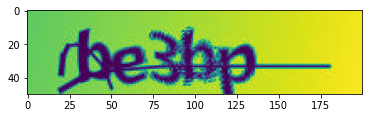

In [186]:
def label2arr(label: str) -> List[int]:
    return [int(x) if x.isnumeric() else 10 + ord(x) - ord('a') for x in label]


def arr2label(arr: List[int]) -> List[str]:
    return [str(x) if x < 10 else chr(x - 10 + ord('a')) for x in arr]


def label2ohe(label: str) -> torch.Tensor:
    arr = [int(x) if x.isnumeric() else 10 + ord(x) - ord('a') for x in label]
    return F.one_hot(
        torch.LongTensor(arr), num_classes=36
    )


def load_captchas(
    path: str = r'sample_data//',
) -> Tuple[List[torch.FloatTensor], List[torch.LongTensor]]:
    show = True
    data, labels = [], []
    for img_path in glob(os.path.join(path, '*.png')):
        class_i = img_path.split(os.sep)[-1].split('.')[-2]
        img = Image.open(img_path).convert("L")
        img_data = img.getdata()
        # arr = np.array(img_data, dtype=np.float32)[:, 0].reshape(img.size[0], img.size[1])
        arr = np.array(img_data, dtype=np.float32).reshape(
            img.size[1], img.size[0])

        data.append(torch.unsqueeze(
            (transforms.ToTensor()(arr)), -1).permute(0, 3, 1, 2))
        labels.append(torch.unsqueeze(torch.LongTensor(label2arr(class_i)), 0))
        # labels.append(torch.unsqueeze(label2ohe(class_i).float(), 0))
        if show:
            print(data[-1].shape)
            show = False
            # plt.imshow(img)
            plt.imshow(arr)
            plt.show()

    arr = list(zip(data, labels))
    random.shuffle(arr)
    data, labels = zip(*arr)

    return list(data), list(labels)


data, labels = load_captchas()


torch.Size([1, 1, 50, 200])
torch.Size([1, 1, 50, 200])


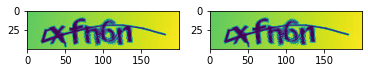

In [187]:
img = data[0]
print(img.shape)
# img = transforms.RandomRotation(degrees=(0, 2), fill=255)(img)
# img1 = transforms.functional.rotate(img, 5, fill=255)
img1 = transforms.RandomPerspective(distortion_scale=0.3, fill=WHITE_FILL)(img)
print(img.shape)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img.squeeze().numpy())
ax[1].imshow(img1.squeeze().numpy())
plt.show()


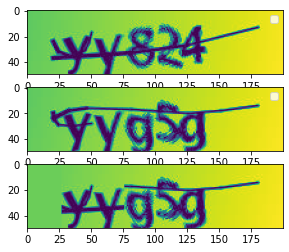

(50, 200)


In [188]:

arr = np.asarray([l.numpy() for l in labels])
arr_data = np.asarray([d.numpy() for d in data])

mask_img = (arr == np.asarray(label2arr('yyn57'))[None, :]).all(axis=2)
img_yyn57 = arr_data[mask_img][0][0]

mask_img = (arr == np.asarray(label2arr('yy824'))[None, :]).all(axis=2)
img_yy824 = arr_data[mask_img][0][0]

mask_img = (arr == np.asarray(label2arr('yw667'))[None, :]).all(axis=2)
img_yw667 = arr_data[mask_img][0][0]

mask_img = (arr == np.asarray(label2arr('yyg5g'))[None, :]).all(axis=2)
img_yyg5g = arr_data[mask_img][0][0]


def generate_new(lab1, lab2, sep1, sep2, sep3):
    mask_img1 = (arr == np.asarray(label2arr(lab1))[None, :]).all(axis=2)
    img1 = arr_data[mask_img1][0][0]

    mask_img2 = (arr == np.asarray(label2arr(lab2))[None, :]).all(axis=2)
    img2 = arr_data[mask_img2][0][0]

    img = np.concatenate((np.full((50, sep1 + sep3-sep2),
                         img1[20, sep1]), img1[:, sep1:sep2], img2[:, sep3:]), axis=1)

    fig, axes = plt.subplots(3)
    axes[0].imshow(img1)
    axes[0].legend()

    axes[1].imshow(img2)
    axes[1].legend()

    axes[2].imshow(img)
    # axes[2].legend()

    plt.show()

    return img, lab1[:2] + lab2[2:]


img, lab = generate_new('yy824', 'yyg5g', sep1=27, sep2=76, sep3=76)
print(img.shape)
idx = random.randint(0, len(data) - 1)
data.insert(idx, torch.unsqueeze(torch.FloatTensor(img), 0).unsqueeze(0))
labels.insert(idx, torch.unsqueeze(torch.LongTensor(label2arr(lab)), 0))


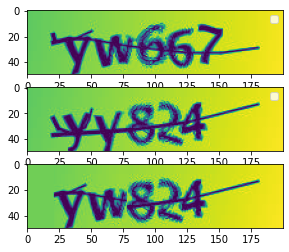

(50, 200)


In [189]:

img, lab = generate_new('yw667', 'yy824', sep1=26, sep2=83, sep3=78)
print(img.shape)
idx = random.randint(0, len(data) - 1)
data.insert(idx, torch.unsqueeze(torch.FloatTensor(img), 0).unsqueeze(0))
labels.insert(idx, torch.unsqueeze(torch.LongTensor(label2arr(lab)), 0))


В результате анализа ошибок стало понятно, что у модели проблемы с 'y' на первом месте. Я добавила в датасет две синтетические картинки с таким символом, более простые, чем настоящие

In [190]:
class DatasetCaptcha(Dataset):
    def __init__(
        self,
        data: List[np.ndarray],
        labels: List[np.ndarray],
        transform: transforms.RandomApply = None,
        test: bool = False,
        test_size: float = 0.2
    ):
        train_len = int(len(data) * (1 - test_size))
        if test:
            data = data[train_len:]
            labels = labels[train_len:]
        else:
            data = data[:train_len]
            labels = labels[:train_len]
        self.data = torch.cat(data)
        self.labels = torch.cat(labels)

        self.transform = transform

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index: int) -> Tuple[torch.FloatTensor, torch.LongTensor]:

        image = self.data[index]
        label = self.labels[index]

        if self.transform is not None:
            image = self.transform(image)

        return image, label


Без использования transforms модель не учится, а сразу переучивается. Поэтому приходится применять к изображениям какие-то искажения. 

load_captchas перемешала датасет, поэтому разделяем на трейн и тест как первые 4 части - трейн, последние - тест.

In [191]:


img_transforms = transforms.RandomApply(nn.ModuleList([
    transforms.RandomAffine(degrees=(-2, 2), fill=WHITE_FILL),
    transforms.RandomRotation(degrees=(-5, 5), fill=WHITE_FILL),
    transforms.RandomAdjustSharpness(1.5),
    transforms.RandomPerspective(distortion_scale=0.2, fill=WHITE_FILL),
]))
training_data = DatasetCaptcha(
    data, labels, transform=img_transforms, test=False, test_size=0.2)
valid_data = DatasetCaptcha(data, labels, test=True, test_size=0.2)

train_loader = DataLoader(training_data, batch_size=64, shuffle=True)
val_loader = DataLoader(valid_data, batch_size=64, shuffle=True)
print(valid_data[0])
print(len(valid_data))

print(len(training_data))


(tensor([[[192., 192., 192.,  ..., 251., 251., 251.],
         [192., 192., 192.,  ..., 251., 251., 251.],
         [192., 192., 192.,  ..., 251., 251., 251.],
         ...,
         [195., 195., 195.,  ..., 254., 254., 254.],
         [195., 195., 195.,  ..., 254., 254., 254.],
         [195., 195., 195.,  ..., 254., 254., 254.]]]), tensor([23,  5, 33,  2, 23]))
209
833


Вот эта модель почему-то не учится. Не удалось подобрать гиперпараметры, чтобы училась. Она значительно меньше, чем та, что в итоге заработала, около 200K параметров, видимо, задача сложнее

In [192]:
class Model1(nn.Module):  # https://medium.com/swlh/captcha-recognition-44522c2fe9c
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, (3, 3)),
            nn.ReLU(),
            nn.Conv2d(32, 32, (3, 3)),
            nn.ReLU(),
            nn.MaxPool2d((1, 2), stride=2),
            nn.Conv2d(32, 64, (3, 3)),
            nn.ReLU(),
            nn.Conv2d(64, 64, (3, 3)),
            nn.ReLU(),
            nn.MaxPool2d((1, 2), stride=2),
            nn.Conv2d(64, 64, (3, 3)),
            nn.ReLU(),
            nn.Conv2d(64, 64, (3, 3)),
            nn.ReLU(),
            nn.MaxPool2d((1, 2), stride=2),
            nn.Conv2d(64, 36, (1, 1)),
            nn.ReLU(),
        )

        self.lin = nn.Sequential(
            nn.Linear(63, 5)
        )

    def forward(self, input):
        input = self.conv(input)

        # input = input.permute(0, 3, 1, 2)
        input = input.view(input.size(0), input.size(1), -1)

        input = self.lin(input)

        # return input.permute(0, 2, 1)
        return input


Вот эта учится, построена на основе статьи из которой иллюстрация

In [193]:
class Model(nn.Module):  # https://www.researchgate.net/publication/348941378_A_limited-size_ensemble_of_homogeneous_CNNLSTMs_for_high-performance_word_classification
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, (3, 3), padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.5),
            nn.MaxPool2d((2, 2), stride=2),
            nn.Conv2d(64, 128, (3, 3), padding=1),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.MaxPool2d((2, 2), stride=2),
            nn.Conv2d(128, 256, (3, 3), padding=1),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.MaxPool2d((1, 2), stride=2),
            nn.Conv2d(256, 512, (3, 3), padding=1),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.BatchNorm2d(512),
            nn.MaxPool2d((1, 2), stride=2),
            nn.Conv2d(512, 512, (2, 2)),
            nn.MaxPool2d((1, 2), stride=2),
            nn.Dropout(0.5),
        )

        self.rnn = nn.Sequential(
            nn.Linear(512, 256),
            nn.LSTM(256, 256, bidirectional=True,
                    batch_first=True, num_layers=2),

        )

        self.lin = nn.Linear(512, 26+10)

    def forward(self, input):
        input = self.conv(input)
        # print(input.shape)

        input = input.permute(0, 3, 1, 2)
        input = input.view(input.size(0), input.size(1), -1)

        input = self.rnn(input)[0]

        return self.lin(input).permute(0, 2, 1)


In [194]:
model = Model()
summary(model, input_size=(BATCH_SIZE, 1, 50, 200))


Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [32, 36, 5]               --
├─Sequential: 1-1                        [32, 512, 1, 5]           --
│    └─Conv2d: 2-1                       [32, 64, 50, 200]         640
│    └─ReLU: 2-2                         [32, 64, 50, 200]         --
│    └─BatchNorm2d: 2-3                  [32, 64, 50, 200]         128
│    └─Dropout: 2-4                      [32, 64, 50, 200]         --
│    └─MaxPool2d: 2-5                    [32, 64, 25, 100]         --
│    └─Conv2d: 2-6                       [32, 128, 25, 100]        73,856
│    └─ReLU: 2-7                         [32, 128, 25, 100]        --
│    └─Dropout: 2-8                      [32, 128, 25, 100]        --
│    └─MaxPool2d: 2-9                    [32, 128, 12, 50]         --
│    └─Conv2d: 2-10                      [32, 256, 12, 50]         295,168
│    └─ReLU: 2-11                        [32, 256, 12, 50]         --
│   

In [197]:
show = True


def train_model(
        model: Model,
        train_loader: DataLoader,
        val_loader: DataLoader,
        loss_fn,
        opt,
        n_epochs: int):
    train_loss = []
    val_loss = []
    val_cer = []
    errors = pd.DataFrame()

    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_cer = []
        start_time = time.time()

        model.train(True)
        for X_batch, y_batch in train_loader:
            global show
            if show:
                show = False
                plt.imshow(X_batch[0].squeeze().numpy())
                plt.show()
            opt.zero_grad()
            y_pred = model(X_batch.to(DEVICE))

            loss = loss_fn(y_pred.to(DEVICE),
                           y_batch.to(DEVICE))
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.)
            opt.step()
            ep_train_loss.append(loss.item())

        model.train(False)
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                y_pred = model(X_batch.to(DEVICE))
                y_pred_label = pd.DataFrame(y_pred.argmax(
                    dim=1).detach().cpu().numpy()).apply(arr2label, axis=1)
                y_batch_label = pd.DataFrame(
                    y_batch.cpu().numpy()).apply(arr2label, axis=1)
                mask = y_pred_label == y_batch_label
                if epoch > 0.8 * n_epochs:
                    errors = pd.concat((
                        errors,
                        pd.concat(
                            (y_pred_label[~mask], y_batch_label[~mask]), axis=1)), axis=0)
                # print(y_pred_[0], y_batch_[0])
                ep_val_cer.append(CharErrorRate()(
                    y_pred_label,
                    y_batch_label
                ))

                loss = loss_fn(y_pred.to(DEVICE),
                               y_batch.to(DEVICE))

                ep_val_loss.append(loss.item())

        # print the results for this epoch:
        print(
            f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_cer.append(np.mean(ep_val_cer))

        print(f"\t  training loss: {train_loss[-1]:.6f}")
        print(f"\tvalidation loss: {val_loss[-1]:.6f}")
        print(f"\tvalidation cer: {val_cer[-1]:.3f}")

    return train_loss, val_loss, val_cer, errors


Из всех комбинаций optimizer, lr, batch_size лучше всего заработало:

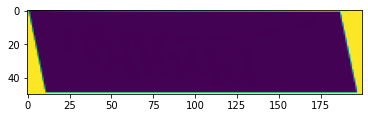

Epoch 1 of 250 took 2.007s
	  training loss: 3.108148
	validation loss: 2.947556
	validation cer: 0.886
Epoch 2 of 250 took 1.721s
	  training loss: 2.973718
	validation loss: 2.953159
	validation cer: 0.888
Epoch 3 of 250 took 1.724s
	  training loss: 2.965581
	validation loss: 2.934854
	validation cer: 0.892
Epoch 4 of 250 took 1.782s
	  training loss: 2.935619
	validation loss: 2.942518
	validation cer: 0.908
Epoch 5 of 250 took 1.806s
	  training loss: 2.954765
	validation loss: 2.941856
	validation cer: 0.892
Epoch 6 of 250 took 1.792s
	  training loss: 2.936032
	validation loss: 2.930880
	validation cer: 0.886
Epoch 7 of 250 took 2.020s
	  training loss: 2.932447
	validation loss: 2.936944
	validation cer: 0.890
Epoch 8 of 250 took 1.759s
	  training loss: 2.947270
	validation loss: 3.183886
	validation cer: 0.899
Epoch 9 of 250 took 1.782s
	  training loss: 2.925185
	validation loss: 2.968794
	validation cer: 0.887
Epoch 10 of 250 took 1.730s
	  training loss: 2.943708
	validati

In [198]:
model = Model().to(DEVICE)
loss = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
train_loss, val_loss, val_cer, errors = train_model(
    model, train_loader, val_loader, loss_fn=loss, opt=optim, n_epochs=250)


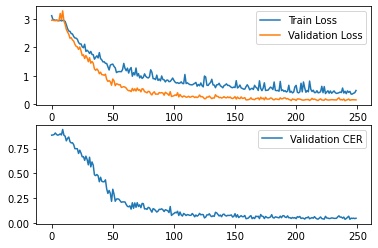

In [199]:
fig, axes = plt.subplots(2)
axes[0].plot(train_loss, label="Train Loss")
axes[0].plot(val_loss, label="Validation Loss")

axes[0].legend()

axes[1].plot(val_cer, label="Validation CER")
axes[1].legend()
plt.show()


# Анализ ошибок

In [200]:
li = list(map(lambda x, y: x + y,
          errors.iloc[:, 0].to_list(), errors.iloc[:, 1].to_list()))
df_errors = pd.DataFrame.from_records(
    li, columns=[f'pred_{i+1}' for i in range(5)] + [f'true_{i+1}' for i in range(5)])


Во время обучения ошибки на тестовой части в конце обучения записывались в dataframe. Ошибки в начале неинформативные, т к веса случайные.

In [201]:
# df_errors = df_errors.iloc[25000:, :]
mask = [df_errors[f'pred_{i+1}'] != df_errors[f'true_{i+1}'] for i in range(5)]


В df_errors в каждой строке 10 символов, первые пять - предсказанные, дальше - истинные. Отдельно рассмотрим ошибки на каждой позиции.

In [202]:
df_errors


,pred_1,pred_2,pred_3,pred_4,pred_5,true_1,true_2,true_3,true_4,true_5
0,p,g,2,n,m,p,g,2,p,m
1,b,n,4,4,w,b,w,4,4,w
2,x,4,g,e,5,x,4,g,g,5
3,5,n,m,f,f,5,n,n,f,f
4,m,e,m,4,f,m,e,n,4,f
...,...,...,...,...,...,...,...,...,...,...
2282,c,5,5,g,5,c,5,5,c,6
2283,m,3,3,5,p,m,3,b,5,p
2284,6,g,n,n,3,6,g,n,m,3
2285,f,w,x,d,n,f,w,x,d,p


In [203]:
from collections import Counter
errors_pos = [df_errors[mask[i]].loc[:, [f'pred_{i+1}', f'true_{i+1}']].groupby(
    by=f'true_{i+1}')[f'pred_{i+1}'].apply(list) for i in range(5)]


Раньше модель в первом символе чаще всего виделат w вместо y, m вместо w. После добавления двух синтетических картинок такой ошибки нет

In [204]:

errors_pos[0].apply(Counter)


true_1
2                     {'7': 6}
3                     {'2': 3}
c                    {'e': 11}
g                     {'c': 2}
m    {'n': 63, 'w': 7, 'y': 2}
n           {'m': 150, 'w': 5}
p     {'e': 4, 'n': 1, 'g': 2}
x                     {'y': 1}
y                    {'x': 11}
Name: pred_1, dtype: object

Во втором символе чаще всего модель видит n вместо p.

In [205]:
errors_pos[1].apply(Counter)


true_2
2                                     {'7': 4, '3': 1}
6                                             {'e': 2}
c                                             {'e': 1}
d                                             {'g': 1}
f                                             {'6': 6}
g                                             {'d': 1}
m                                  {'n': 135, 'w': 14}
n                                    {'m': 83, 'p': 5}
p                                    {'n': 28, 'b': 1}
w                                     {'n': 9, 'y': 1}
x                                             {'y': 6}
y    {'x': 16, 'c': 12, '2': 14, '3': 4, '7': 1, '4...
Name: pred_2, dtype: object

В третьем символе опять n вместо p, еще заметно, что m вместо n.

In [206]:
errors_pos[2].apply(Counter)


true_3
2                                     {'7': 5, '3': 3}
5                                     {'6': 3, 'n': 2}
6                                             {'8': 3}
8                                             {'x': 6}
b                           {'3': 15, '4': 22, '2': 1}
e    {'6': 28, '7': 4, '5': 3, 'g': 1, 'c': 1, 'f':...
f                           {'n': 11, 'm': 38, '7': 1}
g                            {'d': 10, 'e': 5, 'p': 2}
m                                           {'n': 135}
n           {'m': 345, '2': 1, 'y': 2, 'w': 2, 'p': 6}
p                                            {'n': 31}
w    {'n': 1, 'd': 50, 'm': 9, 'g': 9, 'y': 12, 'c'...
x                                     {'3': 1, 'y': 1}
y                                    {'c': 1, 'x': 24}
Name: pred_3, dtype: object

В четвертом символе опять n вместо p, и снова w вместо y. И путает n и m.

In [207]:
errors_pos[3].apply(Counter)


true_4
2                                            {'3': 20}
5                           {'6': 41, '7': 20, 'f': 1}
7                                     {'f': 9, '2': 1}
8                                             {'x': 7}
c            {'e': 39, 'd': 6, '6': 1, 'f': 2, 'g': 3}
e    {'g': 4, 'd': 3, '6': 47, 'c': 7, 'w': 2, 'p':...
f                                             {'4': 2}
g                            {'e': 10, 'd': 6, 'n': 3}
m                                  {'n': 289, 'f': 49}
n                            {'m': 55, 'p': 4, 'b': 1}
p          {'n': 149, 'm': 34, 'x': 1, 'b': 2, '6': 2}
w                 {'x': 29, 'm': 21, 'y': 16, 'g': 25}
x                                     {'y': 1, 'c': 4}
y                                             {'w': 2}
Name: pred_4, dtype: object

In [208]:
errors_pos[4].apply(Counter)


true_5
2              {'y': 9}
3              {'2': 1}
6     {'5': 78, 'n': 5}
7              {'2': 1}
m     {'n': 47, 'w': 1}
n    {'m': 99, 'p': 18}
p    {'b': 21, 'n': 21}
w              {'m': 2}
x             {'c': 12}
Name: pred_5, dtype: object

Раньше больше всего ошибок было в первом и в четвертом. После добавления двух картинок, количество ошибок в первом уменьшилось, в остальных скорее не поменялось.

In [209]:
for x in errors_pos:
    print(x.apply(len).sum())


268
346
812
924
315


Попробуем рассмотреть целиком капчи, которые оказалось сложно распознавать. 

In [210]:
df_errors_whole = pd.DataFrame({'pred': list(map(lambda x: ''.join(
    x[:5]), li)), 'true': list(map(lambda x: ''.join(x[5:]), li))})

df = df_errors_whole.groupby(by=f'true')[f'pred'].apply(list)


In [211]:
df.apply(Counter)


true
22d5n                                        {'22d5m': 23}
23mdg                {'23ndg': 37, '73ndg': 4, '73mdg': 2}
23n88                                         {'23m88': 2}
243mm                                        {'243nm': 41}
25257    {'25252': 1, '25277': 18, '25777': 2, '25357':...
                               ...                        
y4g3b                             {'y4p3b': 1, 'y4d3b': 2}
y5n6d                                         {'y5m6d': 1}
y7mnm                {'y7nnm': 42, 'y7nnn': 1, 'y7mmm': 2}
y7x8p                                         {'y7x8b': 3}
yew6p                                         {'yew6n': 1}
Name: pred, Length: 150, dtype: object

In [212]:
df[df.apply(len) > 10].apply(len)


true
22d5n    23
23mdg    43
243mm    41
25257    23
264m5    21
         ..
wdww8    49
wgnwp    49
x76mn    25
y2ye8    17
y7mnm    45
Name: pred, Length: 64, dtype: int64

Для уменьшения других ошибок можно было бы попробовать добавить в датасет картинку, на которой трудный символ ясно видно. Наверное, если конструировать картинки из кусочков друг друга, повышается вероятность переобучиться.